In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import dataframe_image as dfi

In [22]:
"""
Loads in raw score file
Expecting the schema 
Name	Date	GF	GA	Team

Calcuates result, margies and goal difference
Does some prep work for Form and Win

Obviously names need to be consistant
"""
season = "S3_results"

raw_data = pd.read_csv("../data/"+season+".csv")
raw_data["GD"] = raw_data["GF"] - raw_data["GA"]
raw_data.loc[(raw_data['GD'] == 0), 'GamePoints'] = 0.5
raw_data.loc[(raw_data['GD'] < 0), 'GamePoints'] = -1
raw_data.loc[(raw_data['GD'] > 0), 'GamePoints'] = 1
raw_data.loc[(raw_data['GD'] > 6), 'GamePoints'] = 1.5
raw_data.loc[(raw_data['GD'] < -6), 'GamePoints'] = -1.5
raw_data.loc[(raw_data['GamePoints'] >= 1), 'W'] = 1
raw_data.loc[(raw_data['GamePoints'] == 0.5), 'D'] = 1
raw_data.loc[(raw_data['GamePoints'] <= -1), 'L'] = 1
raw_data.loc[(raw_data['GamePoints'] == 1.5), 'MW'] = 1
raw_data.loc[(raw_data['GamePoints'] == -1.5), 'ML'] = 1

raw_data.loc[(raw_data['GamePoints'] >= 1), 'Result'] = '🔼'
raw_data.loc[(raw_data['GamePoints'] == 0.5), 'Result'] = '➖'
raw_data.loc[(raw_data['GamePoints'] <= -1), 'Result'] = '🔽'
raw_data.loc[(raw_data['GamePoints'] == 1.5), 'Result'] = '⏫'
raw_data.loc[(raw_data['GamePoints'] == -1.5), 'Result'] = '⏬'

raw_data = raw_data[raw_data["Name"].str.contains("\*")==False] # Removes Ringers

raw_data = raw_data.fillna(0)
pd.set_option('display.float_format', '{:.1f}'.format)
raw_data = raw_data.astype({'W':'int','D':'int','L':'int','MW':'int','ML':'int','GF':'int','GA':'int','GD':'int'})

raw_data['Date'] = pd.to_datetime(raw_data['Date'],dayfirst = True)
gameweek_int = raw_data.nunique().Date
gameweek = "Gameweek " + str(gameweek_int)

dates = pd.DataFrame(raw_data.sort_values("Date").Date.unique(),columns=['Date'])
dates['Gameweek'] = dates.index+1

raw_data = raw_data.merge(dates,how='right',on='Date')

pd.set_option('display.max_rows', 50)

display(raw_data)

,Name,Date,GF,GA,Team,GD,GamePoints,W,D,L,MW,ML,Result,Gameweek
0,Noel,2024-08-15,26,15,DARKS,11,1.5,1,0,0,1,0,⏫,1
1,Helmet,2024-08-15,26,15,DARKS,11,1.5,1,0,0,1,0,⏫,1
2,Camilla,2024-08-15,26,15,DARKS,11,1.5,1,0,0,1,0,⏫,1
3,Novak,2024-08-15,26,15,DARKS,11,1.5,1,0,0,1,0,⏫,1
4,Einstein,2024-08-15,15,26,BLANCOS,-11,-1.5,0,0,1,0,1,⏬,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,JD Wetherspoon,2025-05-01,14,10,DARKS,4,1.0,1,0,0,0,0,🔼,37
305,Noel,2025-05-01,10,14,BLANCOS,-4,-1.0,0,0,1,0,0,🔽,37
306,Reaper,2025-05-01,10,14,BLANCOS,-4,-1.0,0,0,1,0,0,🔽,37
307,Gummy,2025-05-01,10,14,BLANCOS,-4,-1.0,0,0,1,0,0,🔽,37


In [23]:
"""
Creates the Form Column
"""
def form_column(raw_data):
    raw_data['game_rank'] = raw_data.sort_values("Date").groupby("Name").Date.rank(ascending=False)
    raw_data_form = raw_data.loc[raw_data['game_rank'] <= 5]
    form = raw_data_form.groupby(['Name'], as_index=False).agg({'Result': ' '.join})
    return form

form = form_column(raw_data)

#display(form)

In [24]:
"""
Creates Matches Played (MP), Partipation (Par%), Pts and Win% (W%)

It also aggreates all the raw data to create an up to date table
"""
def get_totals(raw_data):
    played = raw_data.groupby('Name').count()
    played = pd.DataFrame(played["Date"]).rename(columns={"Date":"MP"})
    data = raw_data.groupby('Name').sum(numeric_only=True).sort_values(by=['GamePoints'],ascending=False).join(played).rename(columns={"GamePoints":"Pts"})

    data["Par%"] = data["MP"].div(gameweek_int)*100
    data["W%"] = data["W"]/data["MP"]*100
    
    data = data.astype({'Par%':'int','W%':'int'})
    data = data.sort_values(by=['Pts','GD'],ascending=False)
    return data

totals = get_totals(raw_data)



#display(totals)


In [25]:
"""
Join tables 
Drops unwanted columns 
Puts columns in the correct order
"""
table = totals.merge(form,on='Name').rename(columns={"Result":"Form"})
table.index = table.Name
table = table[['MP', 'W', 'D', 'L','MW', 'ML', 'GF', 'GA','GD','Par%','W%','Pts','Form']]
table.index.names = [gameweek]
table.dfi.export('../outputs/table.png')
table#.sort_values(by=['MP'],ascending=False)

,MP,W,D,L,MW,ML,GF,GA,GD,Par%,W%,Pts,Form
Gameweek 37,,,,,,,,,,,,,
Gilet,21,14,0,7,2,1,345,313,32,56,66,7.5,⏫ ⏫ ⏬ 🔼 🔼
Gazprom,19,12,1,6,1,1,327,302,25,51,63,6.5,⏬ ⏫ 🔼 🔼 🔼
Golfer,18,11,1,6,0,1,275,276,-1,48,61,5.0,🔼 🔼 🔼 🔽 🔼
Camilla,24,13,1,10,3,2,375,346,29,64,54,4.0,🔽 🔽 🔽 🔼 🔼
Calz,17,10,0,7,2,0,267,243,24,45,58,4.0,🔼 ⏫ 🔽 🔽 🔽
Gummy,18,10,0,8,2,1,294,285,9,48,55,2.5,🔼 🔼 🔼 🔼 🔽
Keysey,14,7,1,6,1,0,214,205,9,37,50,2.0,🔽 ⏫ 🔼 🔽 🔼
Zola,17,9,1,7,0,1,259,260,-1,45,52,2.0,⏬ 🔼 🔼 🔽 🔼
Noel,25,13,0,12,1,1,396,415,-19,67,52,1.0,🔽 🔼 🔽 🔽 🔽


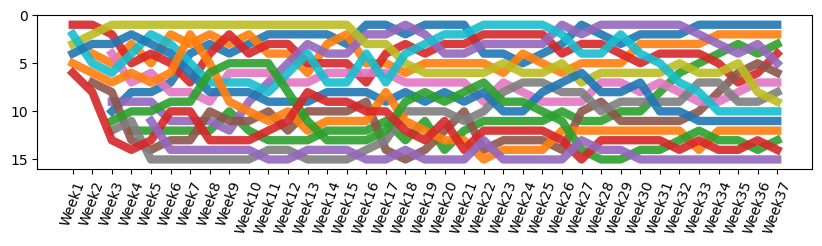

In [26]:
"""
Tracking week by week table position

"""
def get_gameweek(raw_data, Gameweek):

    gameweek_data = raw_data.loc[(raw_data['Gameweek']<=(Gameweek))].reset_index(drop=True)
    gameweek_data = get_totals(gameweek_data)
    table = gameweek_data.merge(form_column(raw_data),on='Name').rename(columns={"Result":"Form"})
    gameweek_column_name = "Week" +str(Gameweek)
    table[gameweek_column_name] = table.index + 1
    table.index = table.Name
    table = table[[gameweek_column_name]]
    return table

def plot_save_bumpchart(raw_data):

    ranked = get_gameweek(raw_data,1)

    for week in range(raw_data['Date'].nunique()-1):
        week = week+2
        ranked = ranked.merge(get_gameweek(raw_data,week),how='right',on='Name')
    ranked.to_csv("../outputs/bumpchart.csv")
    ranked.T.to_csv("../outputs/bumpchart_t.csv")

    plt.figure(figsize=(10,2))
    plt.plot(ranked.T, alpha=0.9, linewidth=6)
    plt.xticks(rotation=70)
    plt.ylim(16, 0)
    #plt.gca().invert_xaxis()
    #plt.xticks(rotation=70)    

    plt.gca().invert_xaxis()
    plt.gca().invert_xaxis()
    plt.show()
    return(ranked)
ranked = plot_save_bumpchart(raw_data)

#https://public.flourish.studio/visualisation/15712793/

In [27]:
"""
Code from Github that creates a bumpchart 
""" 

def bumpchart(df, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)

        left_yaxis.plot(x, y, **line_args, solid_capstyle='round')
        
        # Adding scatter plots
        if scatter:
            left_yaxis.scatter(x, y, **scatter_args)
            
            #Adding see-through holes
            if holes:
                bg_color = left_yaxis.get_facecolor()
                left_yaxis.scatter(x, y, color= bg_color, **hole_args)

    # Number of lines
    lines = len(df.columns)

    y_ticks = [*range(1, lines + 1)]
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    left_yaxis.set_yticklabels(left_labels)
    right_yaxis.set_yticklabels(right_labels)
    
    # Setting the position of the far right axis so that it doesn't overlap with the right axis
    if show_rank_axis:
        far_right_yaxis.spines["right"].set_position(("axes", rank_axis_distance))
    
    return axes

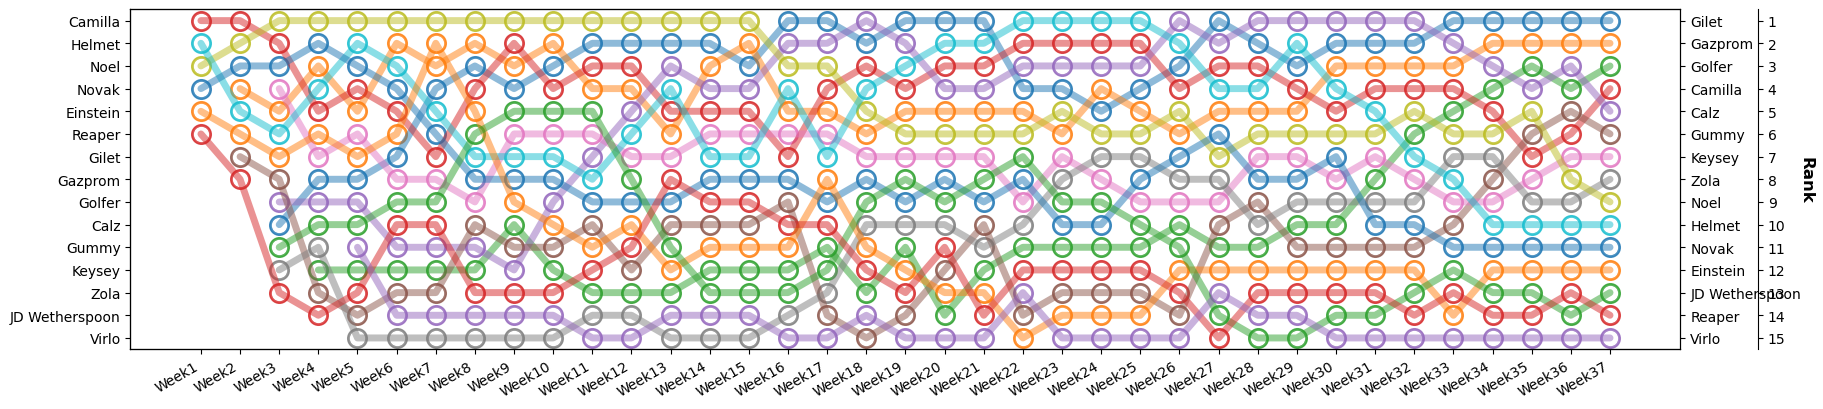

In [28]:
def bumpchart_external(ranked):

    plt.figure(figsize=(20, 5))

    [laxis, raxis, fraxis] = bumpchart(
                               ranked.T, show_rank_axis= True, 
                               rank_axis_distance= 1.05,
                               ax= None, 
                               scatter= True, 
                               holes= True,
                               line_args= {"linewidth": 5, "alpha": 0.5},
                               scatter_args= {"s": 200, "alpha": 0.8},
                               hole_args= {"s": 100, "alpha": 1})



    laxis.set_axisbelow(True)

    fraxis.set_ylabel("Rank", rotation= -90, labelpad= 20, fontsize= 12, weight= "semibold")\

    plt.gcf().autofmt_xdate()

    plt.show()
    
bumpchart_external(ranked)

In [29]:
teams = raw_data.groupby(['Date','Team','Result'])['Name'].apply(','.join).reset_index()
teams[['Player1','Player2','Player3','Player4','Player5']] = teams['Name'].str.split(',',expand=True)
teams = teams.drop('Name',axis=1)
print(teams)

         Date     Team Result   Player1 Player2   Player3         Player4  \
0  2024-08-15  BLANCOS      ⏬  Einstein  Reaper      None            None   
1  2024-08-15    DARKS      ⏫      Noel  Helmet   Camilla           Novak   
2  2024-08-22  BLANCOS      🔽    Helmet  Reaper     Gummy            None   
3  2024-08-22    DARKS      🔼  Einstein   Novak   Gazprom         Camilla   
4  2024-08-29  BLANCOS      🔼      Noel  Reaper  Einstein          Keysey   
..        ...      ...    ...       ...     ...       ...             ...   
69 2025-04-17    DARKS      🔼    Helmet   Gummy    Keysey         Gazprom   
70 2025-04-24  BLANCOS      🔼     Gummy  Reaper   Camilla            None   
71 2025-04-24    DARKS      🔽      Noel  Helmet     Novak            Zola   
72 2025-05-01  BLANCOS      🔽      Noel  Reaper     Gummy           Novak   
73 2025-05-01    DARKS      🔼    Golfer    Zola   Camilla  JD Wetherspoon   

   Player5  
0     None  
1     None  
2     None  
3     Noel  
4     None

In [30]:

df = teams
pair_counts = {}

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    players = row[['Player1', 'Player2', 'Player3', 'Player4', 'Player5']].tolist()

    # Generate unique pairs of players
    player_pairs = [(p1, p2) for p1 in players for p2 in players if p1 != p2]

    for pair in player_pairs:
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1

# Create a new DataFrame from the pair counts
pair_counts_df = pd.DataFrame({'Player Pair': list(pair_counts.keys()), 'Count': list(pair_counts.values())})

# Display the resulting DataFrame
pair_counts_df.sort_values("Count", ascending=False)

,Player Pair,Count
3,"(Reaper, None)",23
5,"(None, Reaper)",23
33,"(None, Gummy)",19
1,"(Einstein, None)",19
4,"(None, Einstein)",19
...,...,...
223,"(Gazprom, Calz)",1
222,"(Calz, Gazprom)",1
219,"(Gilet, Keysey)",1
218,"(Keysey, Gilet)",1


In [31]:
import pandas as pd

# Assuming your DataFrame is named 'df'
# If not, load your data into a DataFrame first

# Create an empty dictionary to store the pair-result counts
pair_result_counts = {}
df = teams
# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    players = row[['Player1', 'Player2', 'Player3', 'Player4', 'Player5']].tolist()

    # Generate unique pairs of players
    player_pairs = [(p1, p2) for p1 in players for p2 in players if p1 != p2]

    for pair in player_pairs:
        if pair in pair_result_counts:
            result = row['Result']
            pair_result_counts[pair][result] = pair_result_counts[pair].get(result, 0) + 1
        else:
            result = row['Result']
            pair_result_counts[pair] = {result: 1}

# Create a new DataFrame from the pair-result counts
pair_result_counts_df = pd.DataFrame(pair_result_counts).fillna(0)

# Display the resulting DataFrame
pair_result_counts_df
transposed_df = pair_result_counts_df.T
transposed_df_cleaned = transposed_df.dropna(axis=0).sort_index(axis=0)
transposed_df_cleaned

⏬   🔼    🔽   ⏫   ➖
Calz Camilla  0.0 2.0  3.0 1.0 0.0
     Einstein 0.0 1.0  0.0 1.0 0.0
     Gazprom  0.0 0.0  1.0 0.0 0.0
     Gilet    0.0 4.0  2.0 1.0 0.0
     Golfer   0.0 1.0  0.0 0.0 0.0
...            ..  ..  ...  ..  ..
NaN  Noel     1.0 7.0  8.0 1.0 0.0
     Novak    0.0 0.0  6.0 1.0 0.0
     Reaper   5.0 5.0 11.0 2.0 0.0
     Virlo    0.0 3.0 14.0 1.0 0.0
     Zola     0.0 6.0  4.0 0.0 0.0

[238 rows x 5 columns]

In [32]:
margie = raw_data[["Date","GD"]]
margie['GD'] = margie['GD'].abs()
margie = margie.drop_duplicates().reset_index(drop=True)
margie['Margie'] = margie.GD.map( lambda x: True if x > 6 else False)
margie

C:\Users\EdmondMitchell\AppData\Local\Temp\ipykernel_48372\171748863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margie['GD'] = margie['GD'].abs()


,Date,GD,Margie
0,2024-08-15,11,True
1,2024-08-22,1,False
2,2024-08-29,3,False
3,2024-09-05,5,False
4,2024-09-12,3,False
5,2024-09-19,4,False
6,2024-09-26,2,False
7,2024-10-03,3,False
8,2024-10-10,1,False
9,2024-10-17,1,False


In [33]:
from datetime import datetime, timedelta

# Starting date
start_date = datetime.now()

# Number of times to repeat the process
iterations = 30

# Loop to run 30 times
for i in range(iterations):
    # Print the current date 10 times
    for j in range(10):
        print(start_date.strftime("%d/%m/%Y"))
    # Increment the date by 7 days
    start_date += timedelta(days=7)

13/05/2025
13/05/2025
13/05/2025
13/05/2025
13/05/2025
13/05/2025
13/05/2025
13/05/2025
13/05/2025
13/05/2025
20/05/2025
20/05/2025
20/05/2025
20/05/2025
20/05/2025
20/05/2025
20/05/2025
20/05/2025
20/05/2025
20/05/2025
27/05/2025
27/05/2025
27/05/2025
27/05/2025
27/05/2025
27/05/2025
27/05/2025
27/05/2025
27/05/2025
27/05/2025
03/06/2025
03/06/2025
03/06/2025
03/06/2025
03/06/2025
03/06/2025
03/06/2025
03/06/2025
03/06/2025
03/06/2025
10/06/2025
10/06/2025
10/06/2025
10/06/2025
10/06/2025
10/06/2025
10/06/2025
10/06/2025
10/06/2025
10/06/2025
17/06/2025
17/06/2025
17/06/2025
17/06/2025
17/06/2025
17/06/2025
17/06/2025
17/06/2025
17/06/2025
17/06/2025
24/06/2025
24/06/2025
24/06/2025
24/06/2025
24/06/2025
24/06/2025
24/06/2025
24/06/2025
24/06/2025
24/06/2025
01/07/2025
01/07/2025
01/07/2025
01/07/2025
01/07/2025
01/07/2025
01/07/2025
01/07/2025
01/07/2025
01/07/2025
08/07/2025
08/07/2025
08/07/2025
08/07/2025
08/07/2025
08/07/2025
08/07/2025
08/07/2025
08/07/2025
08/07/2025
15/07/2025

#### Who has played most together
#### Who has played the least together
#### Everybodys Most Played with Person
#### Best attacker Goals/Games Played
#### Best Defender Conceeded/Games Played
#### Most Wins in a Row
#### Most Losses in a Row
#### Most Margies
#### Most L_Margies
#### Which pair had the best winning rate
#### Which pair had the worst winning rate
#### Most games played in a row
#### Biggest table swing (after X games played)
#### GIF of table position over time
#### Which Team colour won more Darks vs Colours
#### Highest Scoring Game
#### Lowest Scoring Game
#### Ringer Stats
#### Most played Ringer
#### Most points Ringer
#### Whatsapp stats
